# Trajectory Determination 1

This tutorial demonstrates how to determine a simple 1-D trajectory using Kalman filtering.

## Setup

In [1]:
import numpy as np
import pandas as pd

import plotly.graph_objs as go

In [2]:
from ostk.physics.units import Length
from ostk.physics.units import Angle
from ostk.physics.time import Scale
from ostk.physics.time import Instant
from ostk.physics.time import Interval
from ostk.physics.time import Duration
from ostk.physics.time import DateTime
from ostk.physics.coordinate import Frame
from ostk.physics.coordinate.spherical import LLA
from ostk.physics import Environment
from ostk.physics.environment.objects.celestial_bodies import Earth

from ostk.astrodynamics.trajectory import Orbit

from ostk.astrodynamics.trajectory.orbit.models import Kepler
from ostk.astrodynamics.trajectory.orbit.models.kepler import COE

from ostk.astrodynamics.trajectory.orbit.models import SGP4
from ostk.astrodynamics.trajectory.orbit.models.sgp4 import TLE

/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for ostk::physics::time::DateTime already registered; second conversion method ignored.

/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for ostk::math::obj::IntervalBase::Type already registered; second conversion method ignored.



---

In [ ]:
def generate_trajectory (t_0, x_0, v_0, dt, steps):
    
    trajectory = [np.array((t_0, x_0, v_0))]
    
    t = t_0
    
    for _ in range(0, steps):
        
        previous_state = trajectory[-1]
        
        v = previous_state[2]
        
        state = previous_state + np.array((dt, v, 0))
        
        trajectory.append(state)
        
        t += dt
    
    return np.array(trajectory)

In [ ]:
true_trajectory = generate_trajectory(
    t_0 = 0.0,
    x_0 = 0.0,
    v_0 = 0.0,
    dt = 1.0,
    steps = 500
)

In [ ]:
def add_noise_to_trajectory (trajectory, x_noise, v_noise):
    
    def add_noise_to_state (state):
        
        return state + np.array((0.0, np.random.normal(0.0, x_noise), np.random.normal(0.0, v_noise)))
    
    return np.array(list(map(add_noise_to_state, trajectory)))

In [ ]:
noisy_trajectory = add_noise_to_trajectory(
    trajectory = true_trajectory,
    x_noise = 0.10,
    v_noise = 0.01
)

---

## Alpha Beta Filter

In [ ]:
def g_h_filter(data, x0, dx, g, h, dt=1.):
    
    x_est = x0
    results = []
    
    for z in data:
        # print('z = ', z)
        # prediction step
        x_pred = x_est + (dx * dt)
        # print('x_pred = ', x_pred)
        dx = dx

        # update step
        residual = z - x_pred
        # print('residual = ', residual)
        dx = dx + h * (residual) / dt
        x_est = x_pred + g * residual
        # print('x_est = ', x_est)
        results.append(x_est)
        
    return np.array(results)

In [ ]:
estimated_trajectory = g_h_filter(data=noisy_trajectory[1:,1], x0=0., dx=0., g=6./10, h=2./3, dt=1.)

In [ ]:
figure = go.Figure(
    data = [
        go.Scatter(
            name = 'True',
            x = true_trajectory[:,0],
            y = true_trajectory[:,1],
            line = go.scatter.Line(
                color = 'green'
            )
        ),
        go.Scatter(
            name = 'Noisy',
            x = noisy_trajectory[:,0],
            y = noisy_trajectory[:,1],
            line = go.scatter.Line(
                color = 'red'
            )
        ),
        go.Scatter(
            name = 'Estimated',
            x = noisy_trajectory[1:,0],
            y = estimated_trajectory,
            line = go.scatter.Line(
                color = 'blue'
            )
        )
    ]
)

figure.show()

---

In [67]:
true_weights = np.linspace(160.0, 172.0, 12)

In [68]:
measured_weights = [
    158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 
    169.6, 167.4, 166.4, 171.0, 171.2, 172.6
]

In [69]:
measured_weights = [w + np.random.normal(0.0, 1.0) for w in true_weights]

In [70]:
def g_h_filter(data, x0, dx, g, h, dt=1.):
    x_est = x0
    results = []
    for z in data:
        # prediction step
        x_pred = x_est + (dx*dt)
        dx = dx

        # update step
        residual = z - x_pred
        dx = dx + h * (residual) / dt
        x_est = x_pred + g * residual
        results.append(x_est)
    return np.array(results)

estimated_weights = g_h_filter(data=measured_weights, x0=160., dx=1., g=6./10, h=2./3, dt=1.)

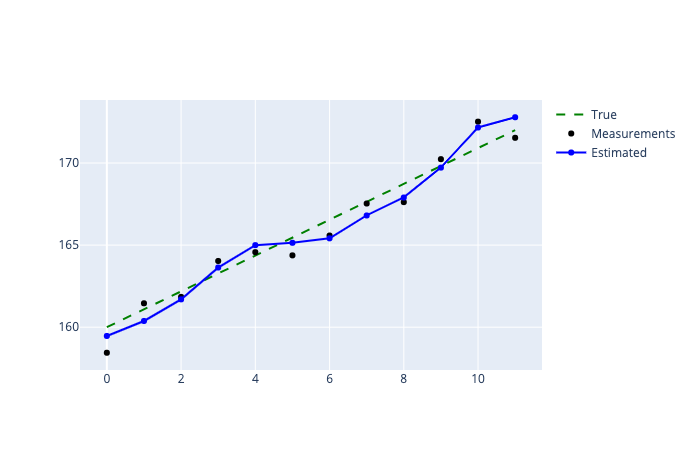

In [71]:
figure = go.Figure(
    data = [
        go.Scatter(
            name = 'True',
            # x = [0, 11],
            y = true_weights,
            mode = 'lines',
            line = go.scatter.Line(
                color = 'green',
                dash = 'dash'
            )
        ),
        go.Scatter(
            name = 'Measurements',
            # x = noisy_trajectory[:,0],
            y = measured_weights,
            mode = 'markers',
            marker = go.scatter.Marker(
                color = 'black'
            )
        ),
        go.Scatter(
            name = 'Estimated',
            # x = noisy_trajectory[1:,0],
            y = estimated_weights,
            line = go.scatter.Line(
                color = 'blue'
            )
        )
    ]
)

figure.show()